In [1]:
import numpy 
from matplotlib import pyplot
from amuse.units import units, constants
from amuse.lab import nbody_system
from amuse.couple import bridge
from amuse.community.huayno import Huayno
from amuse.ic.salpeter import new_salpeter_mass_distribution
from amuse.ic.plummer import new_plummer_model
from amuse.ic.fractalcluster import new_fractal_cluster_model
from amuse.lab import Particle, Particles, units, nbody_system
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

/home/zuzia/miniforge3/lib/python3.12/site-packages/amuse/support/options.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
class MilkyWay_galaxy(object):
    def __init__(
        self, 
        Mb=1.40592e10 | units.MSun,
        Md=8.5608e10 | units.MSun,
        Mh=1.07068e11 | units.MSun,
    ):
        self.Mb = Mb
        self.Md = Md
        self.Mh = Mh

    def get_potential_at_point(self,eps,x,y,z):
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        # bulge
        b1 = 0.3873 | units.kpc
        pot_bulge = -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        # halo
        a3 = 12.0 | units.kpc
        cut_off = 100 | units.kpc
        d1= r/a3
        c = 1+ (cut_off/a3)**1.02
        pot_halo = (
            -constants.G * (self.Mh/a3) * d1**1.02/(1+ d1**1.02)
            -(constants.G*self.Mh/(1.02*a3))
            * (
                -1.02 / c + numpy.log(c) + 1.02/(1+d1**1.02) 
                - numpy.log(1.0 + d1**1.02)
            )
        )
        return 2*(pot_bulge+pot_disk+ pot_halo)  # multiply by 2 because it is a rigid potential
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r = (x**2+y**2+z**2)**0.5
        R = (x**2+y**2)**0.5
        # bulge
        b1 = 0.3873 | units.kpc
        force_bulge = -constants.G*self.Mb/(r**2+b1**2)**1.5 
        # disk
        a2 = 5.31 | units.kpc
        b2 = 0.25 | units.kpc
        d = a2+ (z**2+ b2**2)**0.5
        force_disk = -constants.G*self.Md/(R**2+ d**2 )**1.5
        # halo
        a3 = 12.0 | units.kpc
        d1 = r/a3
        force_halo = -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax = force_bulge*x + force_disk*x  + force_halo*x/r
        ay = force_bulge*y + force_disk*y  + force_halo*y/r
        az = force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax,ay,az

Producing the claster

In [3]:
#setting the initial conditions - number of stars, velocity of the cluster, size of a cluster, position of a cluster
number_of_stars = 100
vel_cluster = 40

masses = new_salpeter_mass_distribution(number_of_stars, 1|units.MSun, 30|units.MSun)
#set to a 1000 particles cluster 
converter = nbody_system.nbody_to_si(masses.sum(), 1|units.parsec)

cluster = new_fractal_cluster_model(number_of_stars, converter)
cluster.mass = masses
cluster.move_to_center()
cluster.position += [8.5, 0, 0] | units.kpc
cluster.velocity += [0, vel_cluster, 0] |units.kms

# print(cluster.x.value_in(units.parsec).min())
# print(cluster.x.value_in(units.parsec).max())

# print(cluster[2].mass)

 



In [ ]:
cluster_star_mass = []
for i in range(len(cluster)):
    cluster_star_mass.append(cluster[i].mass.value_in(units.MSun))

In [5]:
#evolving the system in the Milky Way potential
gravity_code = Huayno(converter)
gravity_code.particles.add_particles(cluster)
channel = gravity_code.particles.new_channel_to(cluster)
MWG = MilkyWay_galaxy()

gravity = bridge.Bridge(use_threading=False)
gravity.add_system(gravity_code, (MWG,) )
gravity.timestep = 1|units.Myr

times = numpy.arange(0.0, 100, 1) | units.Myr


In [6]:
#evolving and storing the positions of stars over time
cluster_over_time_x = numpy.zeros((number_of_stars, times.shape[0]))
cluster_over_time_y = numpy.zeros((number_of_stars, times.shape[0]))
cluster_over_time_z = numpy.zeros((number_of_stars, times.shape[0]))
cluster_over_time_vx = numpy.zeros((number_of_stars, times.shape[0]))
cluster_over_time_vy = numpy.zeros((number_of_stars, times.shape[0]))
cluster_over_time_vz = numpy.zeros((number_of_stars, times.shape[0]))

for j, time in enumerate(times):
    gravity.evolve_model(time)      
    print(gravity.time)
    channel.copy()    
    cluster_over_time_x[:, j] = cluster.x.value_in(units.parsec)
    cluster_over_time_y[:, j] = cluster.y.value_in(units.parsec)
    cluster_over_time_z[:, j] = cluster.z.value_in(units.parsec)
    cluster_over_time_vx[:, j] = cluster.vx.value_in(units.kms)
    cluster_over_time_vy[:, j] = cluster.vy.value_in(units.kms)
    cluster_over_time_vz[:, j] = cluster.vz.value_in(units.kms)

print("done, cleaning up")
gravity.stop()
print(cluster_over_time_vx[90,89])

zero
1 Myr
2 Myr
3 Myr
4 Myr
5 Myr
6 Myr
7 Myr
8 Myr
9 Myr
10 Myr
11 Myr
12 Myr
13 Myr
14 Myr
15 Myr
16 Myr
17 Myr
18 Myr
19 Myr
20 Myr
21 Myr
22 Myr
23 Myr
24 Myr
25 Myr
26 Myr
27 Myr
28 Myr
29 Myr
30 Myr
31 Myr
32 Myr
33 Myr
34 Myr
35 Myr
36 Myr
37 Myr
38 Myr
39 Myr
40 Myr
41 Myr
42 Myr
43 Myr
44 Myr
45 Myr
46 Myr
47 Myr
48 Myr
49 Myr
50 Myr
51 Myr
52 Myr
53 Myr
54 Myr
55 Myr
56 Myr
57 Myr
58 Myr
59 Myr
60 Myr
61 Myr
62 Myr
63 Myr
64 Myr
65 Myr
66 Myr
67 Myr
68 Myr
69 Myr
70 Myr
71 Myr
72 Myr
73 Myr
74 Myr
75 Myr
76 Myr
77 Myr
78 Myr
79 Myr
80 Myr
81 Myr
82 Myr
83 Myr
84 Myr
85 Myr
86 Myr
87 Myr
88 Myr
89 Myr
90 Myr
91 Myr
92 Myr
93 Myr
94 Myr
95 Myr
96 Myr
97 Myr
98 Myr
99 Myr
done, cleaning up
0.925378767785


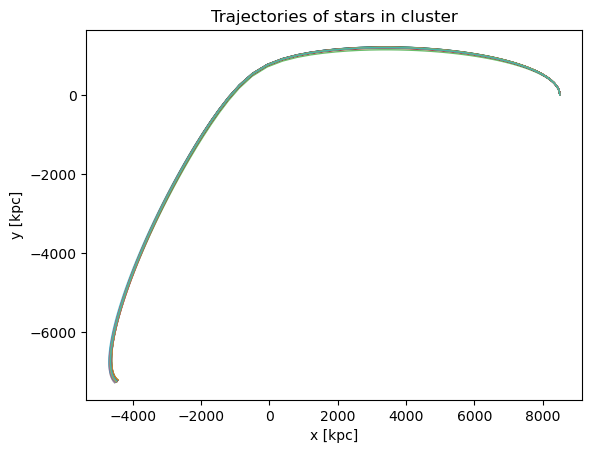

In [7]:
#plotting the trajectories of stars in the cluster

for i in range(number_of_stars):
    # Convert parsecs -> kiloparsecs manually (since no units attached)
    x_vals = cluster_over_time_x[i, :] 
    y_vals = cluster_over_time_y[i, :] 
    z_vals = cluster_over_time_z[i, :] 
    plt.plot(x_vals, y_vals, lw=1, alpha=0.7, label=f"Star {i}")

# x_vals = cluster_over_time_x[1, :] / 1000.0   # 1 kpc = 1000 pc
# y_vals = cluster_over_time_y[1, :] / 1000.0
# plt.plot(x_vals, y_vals, lw=1, alpha=0.7, label=f"Star {i}")

plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")

plt.title("Trajectories of stars in cluster")
#plt.legend()
plt.show()


KeyboardInterrupt: 

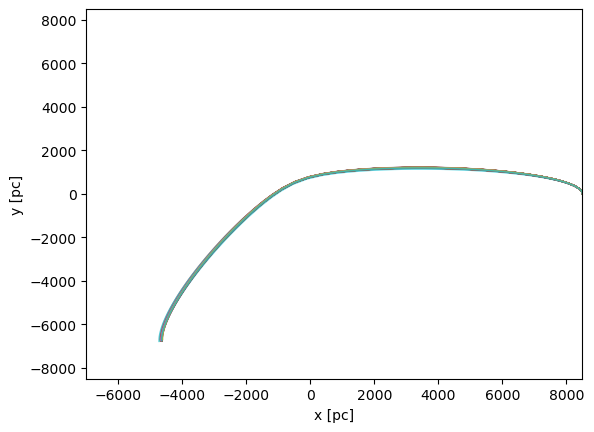

In [8]:

#animating the trajectories of stars in the cluster
# Do not run for all stars it is taking 17 minutes to load
fig,ax = plt.subplots()

lines = []

# Convert parsecs -> kiloparsecs manually (since no units attached)
for i in range(number_of_stars):
    # Convert parsecs -> kiloparsecs manually (since no units attached)
    x_vals = cluster_over_time_x[i, 0] 
    y_vals = cluster_over_time_y[i, 0] 
    
    line = ax.plot(x_vals, y_vals, lw=1, alpha=0.7, label=f"Star {i}")
    lines.append(line)

ax.set(xlim=[-7000, 8500], ylim=[-8500, 8500], xlabel="x [pc]", ylabel="y [pc]")

def update(frame):
    for i in range (number_of_stars):
        x = cluster_over_time_x[i, :frame] 
        y = cluster_over_time_y[i, :frame]
        lines[i][0].set(xdata=x, ydata=y)
    return lines 


#plt.legend()
ani = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=30)
from IPython.display import HTML
HTML(ani.to_jshtml())
# ani.save(filename="animacja.gif", writer="pillow")
# plt.show()


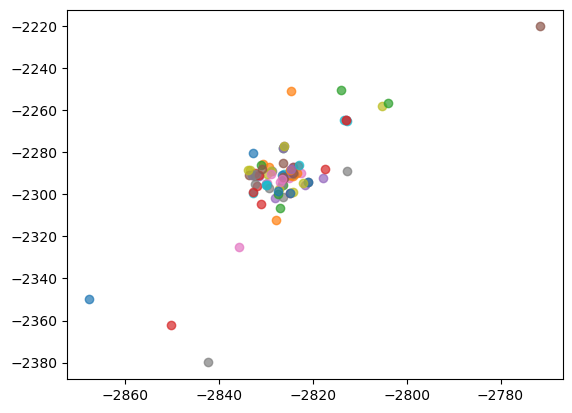

In [9]:
#nice plot to see how the cluster is destroyed
for i in range(number_of_stars):
    x_vals = cluster_over_time_x[i, 60] 
    y_vals = cluster_over_time_y[i, 60] 
    plt.scatter(x_vals, y_vals, lw=1, alpha=0.7, label=f"Star {i}")

Hill radius interactions 

In [8]:
#Setting hill radius - initial condition

R_hill = 1000 | units.au
R_hill_pc = R_hill.value_in(units.parsec)

print(R_hill_pc)

0.00484813681113


In [9]:
#setting up the reactions matrix

reactions = numpy.zeros((number_of_stars,number_of_stars))
for main_star in range(number_of_stars):
    for j in range(number_of_stars):
        a = R_hill * (3*cluster[j].mass/cluster[main_star].mass)**(1/3)
        a = 1000 | units.au
        reactions[main_star, j] = a.value_in(units.parsec)
print(reactions[9][8])





0.00484813681113


In [ ]:
# #testing code to look for an reaction only for star nr 2
# reactions_star_1 = []
# main_star = 2

# for j in range(number_of_stars):
#     if j == main_star :
#         continue

#     for ti, t in enumerate(times):
    
#         main_star_x = cluster_over_time_x[ main_star, ti] 
#         main_star_y = cluster_over_time_y[main_star, ti] 

#         other_star_x = cluster_over_time_x[ j, ti] 
#         other_star_y = cluster_over_time_y[ j, ti] 

#         d = ((main_star_x - other_star_x )**2 + (main_star_y - other_star_y)**2)**0.5

#         if d< reactions[main_star][j]:
#             reactions_star_1.append((j, ti, d))
        
            
            

# print(len(reactions_star_1))
        

0


In [ ]:
## testing code to look for reactions for all stars - really slow for nicer code look down below

# interactions_list = []

# for main_star in range(number_of_stars):

#     reactions_star = []

#     for ti, t in enumerate(times):
#         for j in range(number_of_stars):
#             if j == main_star :
#                 continue
#             main_star_x = cluster_over_time_x[ main_star, ti] 
#             main_star_y = cluster_over_time_y[main_star, ti] 

#             other_star_x = cluster_over_time_x[ j, ti] 
#             other_star_y = cluster_over_time_y[ j, ti] 

#             d = ((main_star_x - other_star_x )**2 + (main_star_y - other_star_y)**2)**0.5

#             if d< reactions[main_star][j]:
#                 reactions_star.append((j, ti, d))
#                 print(reactions_star)
                
#     interactions_list.append(reactions_star)
# print(len(interactions_list))

    
        

KeyboardInterrupt: 

In [12]:
# Optimize interaction search: iterate over time steps, using KD-tree
max_radius = reactions.max()  # scalar (parsec)
T = times.shape[0]
N = number_of_stars

# Prepare positions per time: shape (T, N, 3)
positions_by_time = numpy.stack((cluster_over_time_x.T,
                                 cluster_over_time_y.T,
                                 cluster_over_time_z.T), axis=2)
velocity_by_time = numpy.stack((cluster_over_time_vx.T,
                                cluster_over_time_vy.T,
                                cluster_over_time_vz.T), axis=2)

# Initialize list of interactions for each star
interactions_list = [[] for _ in range(N)]

for ti in range(T):
    pos = positions_by_time[ti]  # (N,3), units: parsec
    vel = velocity_by_time[ti]   # (N,3), units: km/s
    
    # Build KD-tree for fast neighbor search
    tree = cKDTree(pos)
    
    # neighbors_list[i] contains indices of stars within max_radius of star i (includes i itself)
    neighbors_list = tree.query_ball_tree(tree, r=float(max_radius))
    
    for i, neigh in enumerate(neighbors_list):
        if len(neigh) <= 1:
            continue
        
        # Remove self from neighbors
        neigh = [j for j in neigh if j != i]
        if not neigh:
            continue
        
        neigh = numpy.array(neigh, dtype=int)
        
        # Differences in positions and velocities
        dx = pos[neigh, 0] - pos[i, 0]
        dy = pos[neigh, 1] - pos[i, 1]
        dz = pos[neigh, 2] - pos[i, 2]
        dvx = vel[neigh, 0] - vel[i, 0]
        dvy = vel[neigh, 1] - vel[i, 1]
        dvz = vel[neigh, 2] - vel[i, 2]
        
        # Distances and relative velocities
        dists = numpy.hypot(dx, dy, dz)   # distances in parsec
        vels = numpy.hypot(dvx, dvy, dvz) # relative velocities in km/s

        # Compute mass ratio
        if cluster.mass[i].value_in(units.MSun) > cluster.mass[neigh].value_in(units.MSun):
            mass_ratio = cluster.mass[i].value_in(units.MSun) / cluster.mass[neigh].value_in(units.MSun)
        else:
            mass_ratio = cluster.mass[neigh].value_in(units.MSun) / cluster.mass[i].value_in(units.MSun)

        
        # Filter by per-pair threshold
        mask = dists < reactions[i, neigh]
        hit_idx = neigh[mask]
        hit_dists = dists[mask]
        hit_vels = vels[mask]
        
        
        # Save interactions
        for j_idx, dist, relativ_vel in zip(hit_idx, hit_dists, hit_vels):
            interactions_list[i].append((int(i), int(j_idx), times[ti], dx, dy, dz, dvx, dvy, dvz , dists, cluster.mass[i].value_in(units.MSun), cluster.mass[j_idx].value_in(units.MSun), mass_ratio))
    
    if ti % 50 == 0:
        print(f"time {ti}/{T}")

# Summary
print("done, stars with interactions:", sum(1 for lst in interactions_list if lst))
interactions_list_filtered = [lst for lst in interactions_list if lst]
print(interactions_list_filtered)




time 0/100
time 50/100
done, stars with interactions: 18
[[(0, 51, quantity<49.0 Myr>, array([-0.00088708]), array([-0.00034348]), array([ 0.00095125]), array([ 4.52422629]), array([ 5.10651358]), array([ 6.82239727]), array([ 0.00095125]), 3.6547097887117697, 1.985903488533435, array([ 1.84032598])), (0, 51, quantity<65.0 Myr>, array([-0.00164442]), array([-0.00114691]), array([ 0.00200487]), array([ 2.50580595]), array([ 3.72811589]), array([ 4.49198303]), array([ 0.00200487]), 3.6547097887117697, 1.985903488533435, array([ 1.84032598]))], [(10, 38, quantity<19.0 Myr>, array([ 0.00186206]), array([ 0.00013676]), array([ 0.00186707]), array([-1.24941536]), array([-1.262961]), array([ 1.77654418]), array([ 0.00186707]), 1.1167430437981742, 1.4121572558882556, array([ 1.26453195])), (10, 38, quantity<59.0 Myr>, array([-0.0008889]), array([ 0.00354202]), array([ 0.00365186]), array([ 0.21907341]), array([ 1.58790167]), array([ 1.60294257]), array([ 0.00365186]), 1.1167430437981742, 1.412

In [13]:
print(len(interactions_list_filtered))


18


In [14]:
import csv

# Flatten the list of lists into a single list of interactions
#all_interactions = [item for sublist in interactions_list_filtered for item in sublist]
all_interactions = []
for interakcja in interactions_list_filtered:
    #print(interakcja)
    for lista in interakcja:
        all_interactions.append(lista)


with open("interactions.csv", "w", newline="") as f:
    writer = csv.writer(f)
    # Write header
    writer.writerow(["star_i", "star_j", "time " ,"relative_dx_pc", "relative_dy_pc", "relative_dz_pc", "relative_dvx_kms", "relative_dvy_kms", "relative_dvz_kms", "distance_pc", "mass_star_i_MSun",  "mass_star_j_MSun", "mass_ratio"])
    # Write data
    writer.writerows(all_interactions)

print("Saved interactions to interactions.csv")


Saved interactions to interactions.csv


In [59]:
import pandas as pd
data = pd.DataFrame(all_interactions, columns=["star_i", "star_j", "time " ,"relative_dx_pc", "relative_dy_pc", "relative_dz_pc", "relative_dvx_kms", "relative_dvy_kms", "relative_dvz_kms", "distance_pc", "mass_star_i_MSun",  "mass_star_j_MSun", "mass_ratio"])

#print(data)

Finding the stars with the closest approach and biggest mass ratio

In [60]:
interesting_stars_number = 3

data['star_i'] = data['star_i'].astype(int)
data['star_j'] = data['star_j'].astype(int)

# Build unordered pair key so (i,j) and (j,i) are treated the same
data['pair'] = data.apply(lambda r: tuple(sorted((int(r['star_i']), int(r['star_j'])))), axis=1)


distance_min = data.sort_values('distance_pc').drop_duplicates('pair')


#print(distance_min)

#print(distance_min.head(interesting_stars_number))

interesting_stars = distance_min.head(interesting_stars_number)

interesting_stars['why'] = 'distance'

interesting_stars = interesting_stars.reset_index(drop=True)

#print(interesting_stars)

mass_ratio_max = data.sort_values('mass_ratio', ascending=False).drop_duplicates('pair').head(interesting_stars_number)
mass_ratio_max['why'] = 'mass_ratio'
#print(mass_ratio_max.iloc[0])

existing_pairs = interesting_stars['pair'].tolist()
for i in range(len(mass_ratio_max)):
    if mass_ratio_max.iloc[i]['pair'] in existing_pairs:
        interesting_stars.loc[interesting_stars['pair'] == mass_ratio_max.iloc[i]['pair'], 'why'] += 'mass_ratio'
    else:
        interesting_stars.loc[len(interesting_stars)] = mass_ratio_max.iloc[i]
    
    




/tmp/ipykernel_9822/1228137326.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interesting_stars['why'] = 'distance'


Print to see if we can simulate it

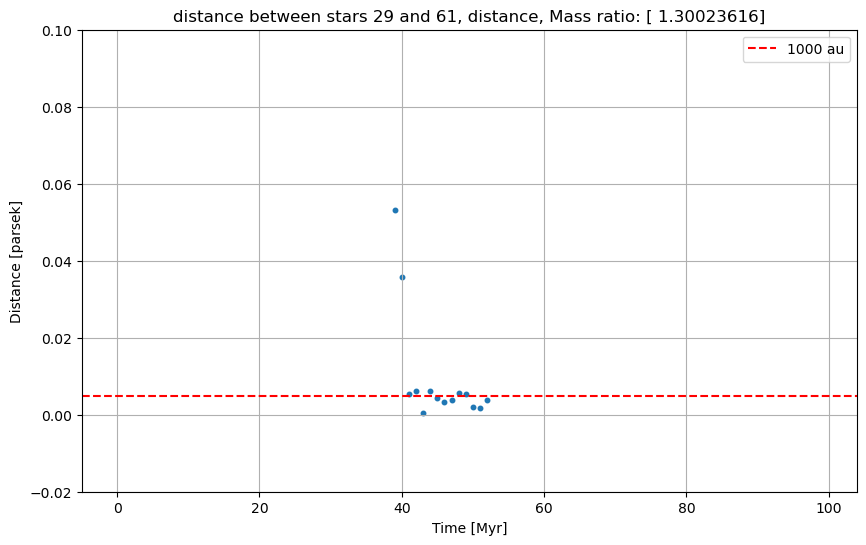

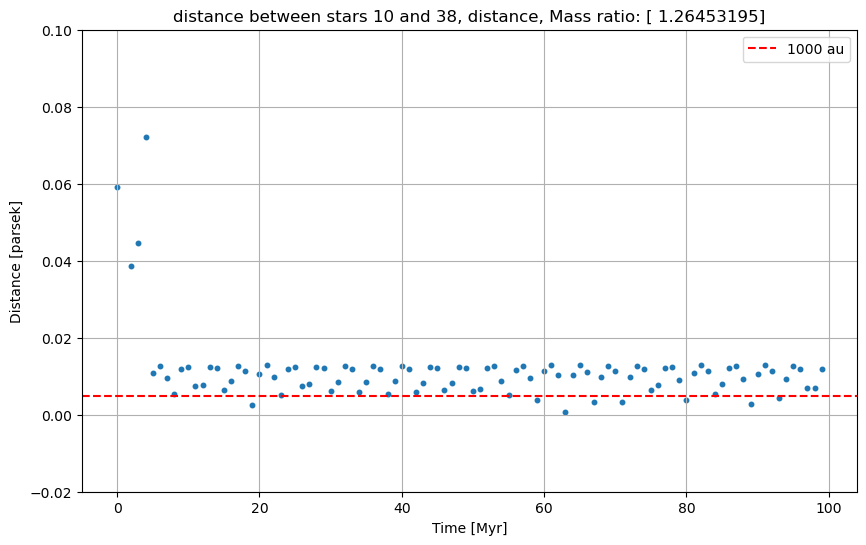

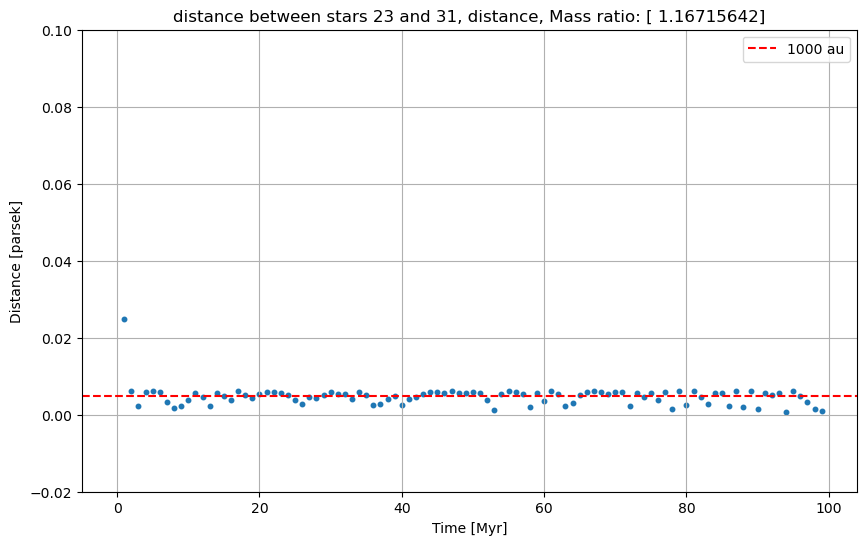

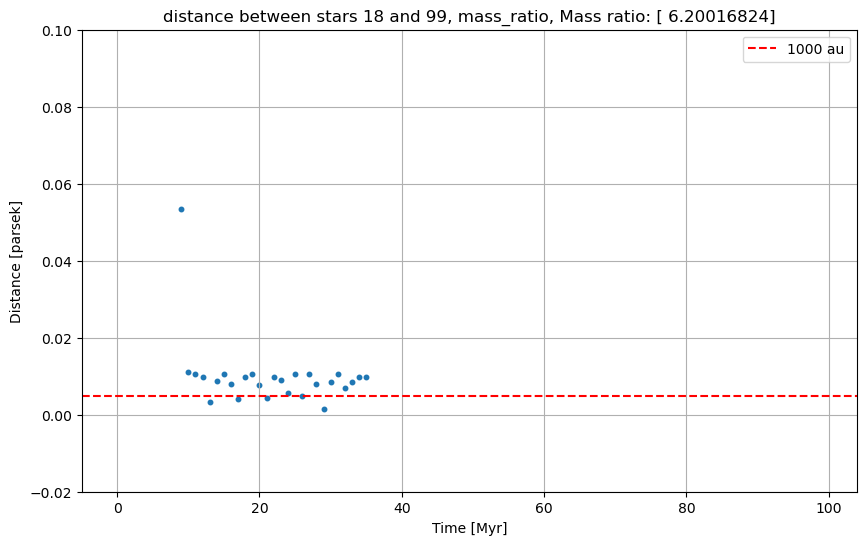

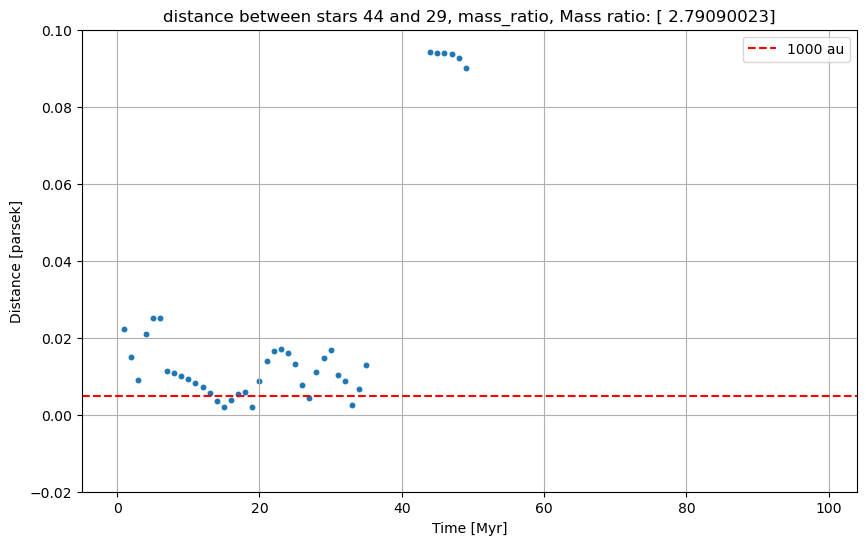

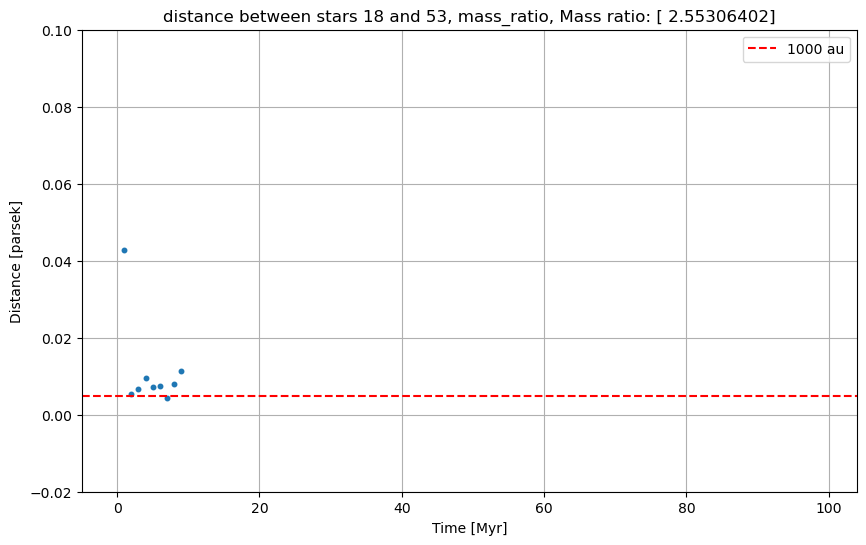

In [71]:
for pair in range(len(interesting_stars)):
    i = interesting_stars.iloc[pair]['star_i']
    j = interesting_stars.iloc[pair]['star_j']
    
    distances = numpy.sqrt(
    (cluster_over_time_x[i, :] - cluster_over_time_x[j, :])**2 +
    (cluster_over_time_y[i, :] - cluster_over_time_y[j, :])**2 +
    (cluster_over_time_z[i, :] - cluster_over_time_z[j, :])**2)

    time_values = times.value_in(units.Myr)  
    time_label = "Time [Myr]"

    plt.figure(figsize=(10,6))
    plt.scatter(time_values, distances, s=5, linewidths=2)
    plt.xlabel(time_label)
    plt.axhline(0.0048481368, color='red', linestyle='--', lw=1.5, label='1000 au')
    plt.ylabel("Distance [parsek]")
    plt.title(f"distance between stars {i} and {j}, {interesting_stars.iloc[pair]['why']}, Mass ratio: {interesting_stars.iloc[pair]['mass_ratio']}")
    plt.ylim(-0.02, 0.1)
    plt.legend()
    plt.grid(True)
    plt.show()


Finding the stars with more than one unique interactions

In [58]:


unique = data.drop_duplicates('pair')
# print(unique)
is_js =  pd.concat([unique['star_i'], unique['star_j']])
print(is_js.value_counts())

99    3
29    3
61    2
18    2
10    1
0     1
30    1
35    1
58    1
23    1
51    1
38    1
53    1
31    1
44    1
50    1
52    1
60    1
Name: count, dtype: int64
